In [2]:
import system_code as tsc

n_dot = 8.99e-7  # kg T burned / s
TBR = 1.1
TBE = 0.005

# OFC
plasma = tsc.Box("plasma", volume=1, generation_term=-n_dot)
blanket = tsc.Box("blanket", volume=1, generation_term=n_dot * TBR)
first_wall = tsc.Box("first wall", volume=1)
divertor = tsc.Box("divertor", volume=1)
t_extraction_system = tsc.Box("TES", volume=1)
heat_exchanger = tsc.Box("HX", volume=1)

# IFC
fueling_system = tsc.Box("fueling system", volume=1)
storage_and_management = tsc.Box(
    "storage and management", volume=1, initial_concentration=3
)
isotope_seperation_system = tsc.Box("ISS", volume=1)
vacuum_pump = tsc.Box("vacuum pump", volume=1)
fuel_cleanup = tsc.Box("fuel cleanup", volume=1)
detritiation_system = tsc.Box("detritiation system", volume=1)

# links
f_p_fw = 1e-4
f_p_div = 1e-4
f_p_vaccum_pump = 1 - TBE - f_p_fw - f_p_div
plasma.add_constant_output(first_wall, flow=f_p_fw * n_dot / TBE)
plasma.add_constant_output(divertor, flow=f_p_div * n_dot / TBE)
plasma.add_constant_output(vacuum_pump, flow=f_p_vaccum_pump * n_dot / TBE)

tau_bz = 3600  # s
blanket.add_output(t_extraction_system, flowrate=blanket.volume / tau_bz)
blanket.add_output(
    first_wall, flowrate=0
)  # can't find info in paper , assuming zero for now
blanket.add_output(
    divertor, flowrate=0
)  # can't find info in paper , assuming zero for now

tau_fw = 1000  # s
first_wall.add_output(blanket, flowrate=first_wall.volume / tau_fw)

tau_div = 1000  # s
divertor.add_output(blanket, flowrate=divertor.volume / tau_div)

tau_tes = 24 * 3600  # s
eta_tes = 0.9
t_extraction_system.add_output(
    heat_exchanger, flowrate=(1 - eta_tes) * t_extraction_system.volume / tau_tes
)
t_extraction_system.add_output(
    isotope_seperation_system, flowrate=eta_tes * t_extraction_system.volume / tau_tes
)

tau_hx = 1000  # s
f_hx_det_sys = 1e-4
heat_exchanger.add_output(
    blanket, flowrate=(1 - f_hx_det_sys) * heat_exchanger.volume / tau_hx
)
heat_exchanger.add_output(
    detritiation_system, flowrate=f_hx_det_sys * heat_exchanger.volume / tau_hx
)

tau_iss = 3.7 * 3600  # s
f_iss_det_sys = 0.1
isotope_seperation_system.add_output(
    storage_and_management,
    flowrate=(1 - f_iss_det_sys) * isotope_seperation_system.volume / tau_iss,
)
isotope_seperation_system.add_output(
    detritiation_system,
    flowrate=f_iss_det_sys * isotope_seperation_system.volume / tau_iss,
)

tau_det = 1 * 3600  # s
detritiation_system.add_output(
    isotope_seperation_system, flowrate=detritiation_system.volume / tau_det
)

tau_vp = 600  # s
f_DIR = 0.5
vacuum_pump.add_output(fuel_cleanup, flowrate=(1 - f_DIR) * vacuum_pump.volume / tau_vp)
vacuum_pump.add_output(
    storage_and_management, flowrate=f_DIR * vacuum_pump.volume / tau_vp
)  # DIR

tau_fc = 0.3 * 3600  # s
fuel_cleanup.add_output(
    isotope_seperation_system, flowrate=fuel_cleanup.volume / tau_fc
)

fueling_system.add_constant_output(plasma, flow=n_dot / TBE)

storage_and_management.add_constant_output(fueling_system, flow=n_dot / TBE)

# system

system = tsc.System(
    [
        plasma,
        blanket,
        divertor,
        first_wall,
        t_extraction_system,
        heat_exchanger,
        isotope_seperation_system,
        detritiation_system,
        vacuum_pump,
        fuel_cleanup,
        fueling_system,
        storage_and_management,
    ],
    dt=1000
)

system.run(70 * 24 * 3600)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0, 0.5, 'Inventories (kg)')

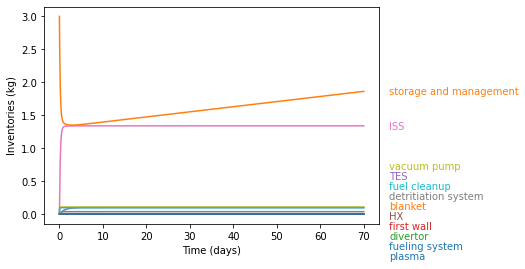

In [10]:
import matplotlib.pyplot as plt
import matplotx
import numpy as np

for box in system.boxes:
    plt.plot(np.array(system.t)/3600/24, box.concentrations, label=box.name)

matplotx.line_labels()
plt.xlabel("Time (days)")
plt.ylabel("Inventories (kg)")


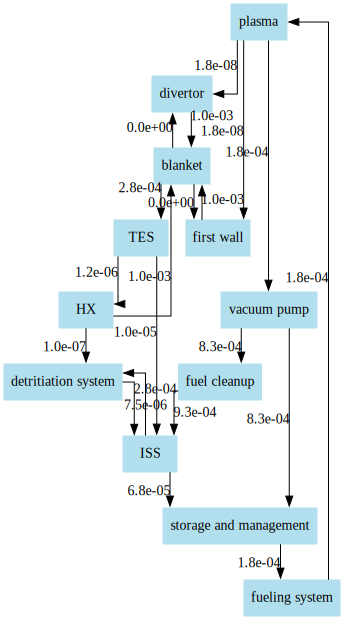

In [20]:
import graphviz
graph = graphviz.Digraph('system-graph', comment='My System Graph', graph_attr={'splines': 'ortho'}, node_attr={'color': 'lightblue2', 'style': 'filled'})


for box in system.boxes:
    graph.node(box.name, box.name, shape='box')

for box in system.boxes:
    for output, flowrate in box.outputs.items():
        graph.edge(box.name, output.name, xlabel=f"{flowrate:.1e}")

    for output, flow in box.constant_outputs.items():
        graph.edge(box.name, output.name, xlabel=f"{flow:.1e}")

graph